In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sales_processing import add_date_features, normalize_sales, denormalize_sales, fill_in_dates, kung_i_baren, normalize_sales_chunk, normalize_sales_month, normalize_sales_year, add_closed_days, find_closed_patterns, find_closed_ranges
from holiday_processing import add_holidays
from weather_processing import add_weather_info
from covid_processing import add_covid_info


In [3]:
df = pd.read_csv('data/caspecoTrainingData.csv')
weather = pd.read_csv('data/uppsala_weather.csv')
holidays = pd.read_csv('data/swedish_holidays.csv')
dates = pd.date_range('2020-01-01', '2023-01-04')
covid = pd.read_csv('data/Folkhalsomyndigheten_Covid19.csv')
from sklearn.preprocessing import normalize
# normalize sales for each company using sklearn normalize
sales = df.copy()
sales = fill_in_dates(sales, dates)
sales = add_date_features(sales)
sales, norms = normalize_sales_month(sales)
sales = add_holidays(sales, holidays)
#sales = add_weather_info(sales, weather)
sales = kung_i_baren(sales)
#sales = add_closed_days(sales)
#sales = add_covid_info(sales, covid)
sales.columns = sales.columns.str.title()
sales[sales['Sales'] == 0].head(12)
sales = find_closed_patterns(sales)
sales = find_closed_ranges(sales, verbose=True)

Company 0 closed between 2020-07-04 00:00:00 and 2020-08-10 00:00:00
Company 0 closed between 2021-04-02 00:00:00 and 2021-04-05 00:00:00
Company 1 closed between 2020-08-03 00:00:00 and 2020-09-30 00:00:00
Company 1 closed between 2022-06-24 00:00:00 and 2022-07-08 00:00:00


In [4]:
# one hot encode the categorical variables
categorical_features = ['Company', 'Weekday', 'Month', 'Week']
sales = pd.get_dummies(sales, columns=categorical_features)
sales.drop(columns=['Payweek', 'Day', 'Year'], inplace=True)
sales

,Date,Sales,Weekend,Workday,Holiday,Holieve,Payday,Closed,Company_0,Company_1,...,Week_44,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53
2,2020-01-01,0.000000,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01,0.000000,0,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
0,2020-01-01,0.061529,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2020-01-02,0.088216,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-02,0.163186,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,2023-01-03,0.137047,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3294,2023-01-03,0.150638,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3299,2023-01-04,0.122110,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3298,2023-01-04,0.126884,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:

"""
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.svm import SVR



X = sales.drop(columns=['Date', 'Sales'])
y = sales['Sales']

rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [60,80,100],
    'max_depth': [40,50, 60],
    'min_samples_split': [5,6,7],
}
#cv = cross_validate(rf, X, y, scoring='r2', cv=5, n_jobs=-1, verbose=1, )
rf_grid = GridSearchCV(rf, param_grid, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X, y)

params = rf_grid.best_params_
"""

"\nfrom sklearn.model_selection import cross_validate, GridSearchCV\nfrom sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor\nfrom sklearn.metrics import make_scorer, confusion_matrix\nfrom sklearn.svm import SVR\n\n\n\nX = sales.drop(columns=['Date', 'Sales'])\ny = sales['Sales']\n\nrf = RandomForestRegressor()\nparam_grid = {\n    'n_estimators': [60,80,100],\n    'max_depth': [40,50, 60],\n    'min_samples_split': [5,6,7],\n}\n#cv = cross_validate(rf, X, y, scoring='r2', cv=5, n_jobs=-1, verbose=1, )\nrf_grid = GridSearchCV(rf, param_grid, scoring='r2', n_jobs=-1, verbose=1)\nrf_grid.fit(X, y)\n\nparams = rf_grid.best_params_\n"

In [6]:
#print(rf_grid.best_score_)
#print(params)


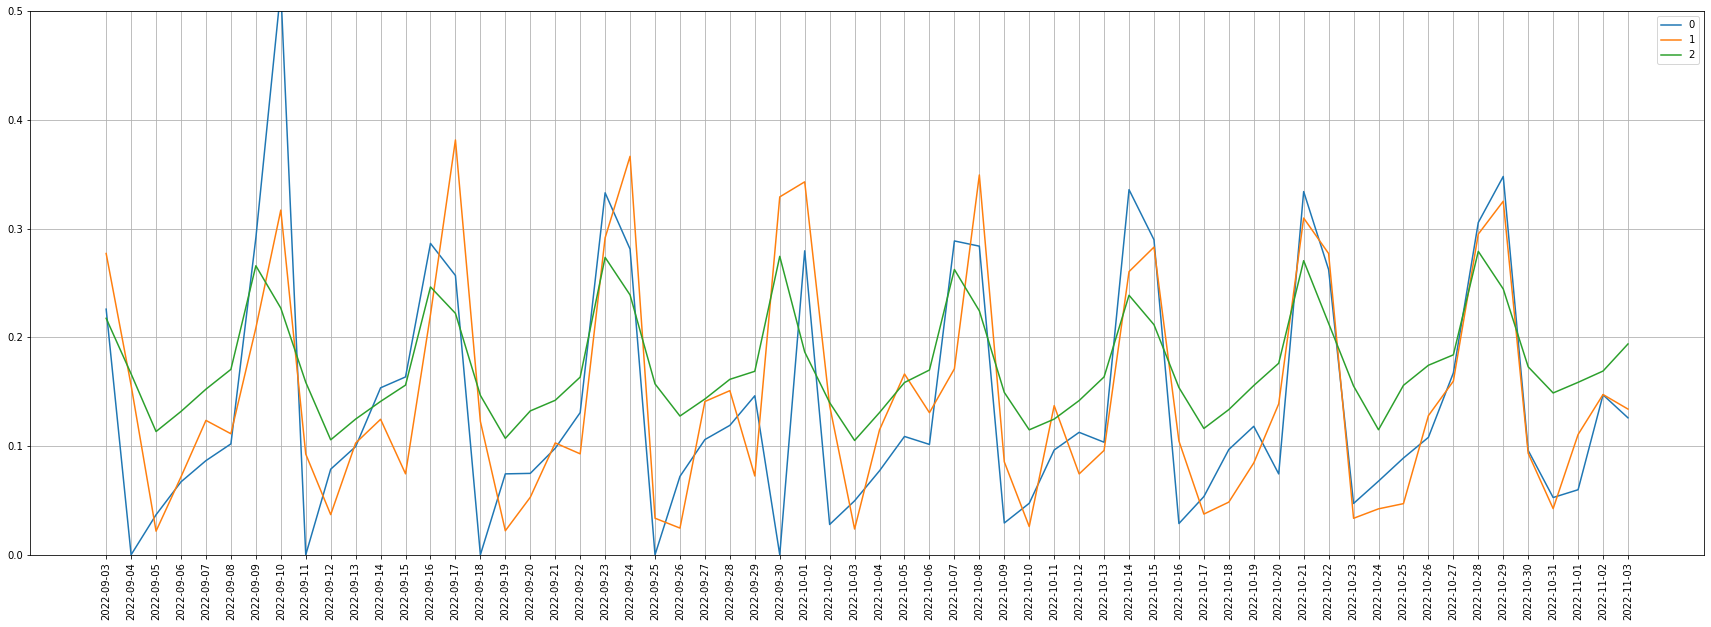

In [7]:
startdate = '2022-09-03'
enddate = '2022-11-03'

plt.figure(figsize=(30, 10))
for company in [0,1,2]:
    companycol = f"Company_{company}"
    companySales = sales[sales[companycol] == 1]
    companySalesFiltered = companySales[(companySales['Date'] >= startdate) & (companySales['Date'] <= enddate)]
    plt.plot(companySalesFiltered['Date'], companySalesFiltered['Sales'], label=company)
# set xticks to every date unique date within range
plt.xticks(sales['Date'][(sales['Date'] >= startdate) & (sales['Date'] <= enddate)].unique(), rotation=90)
plt.ylim(0, 0.5)
plt.grid()
plt.legend()
plt.show()

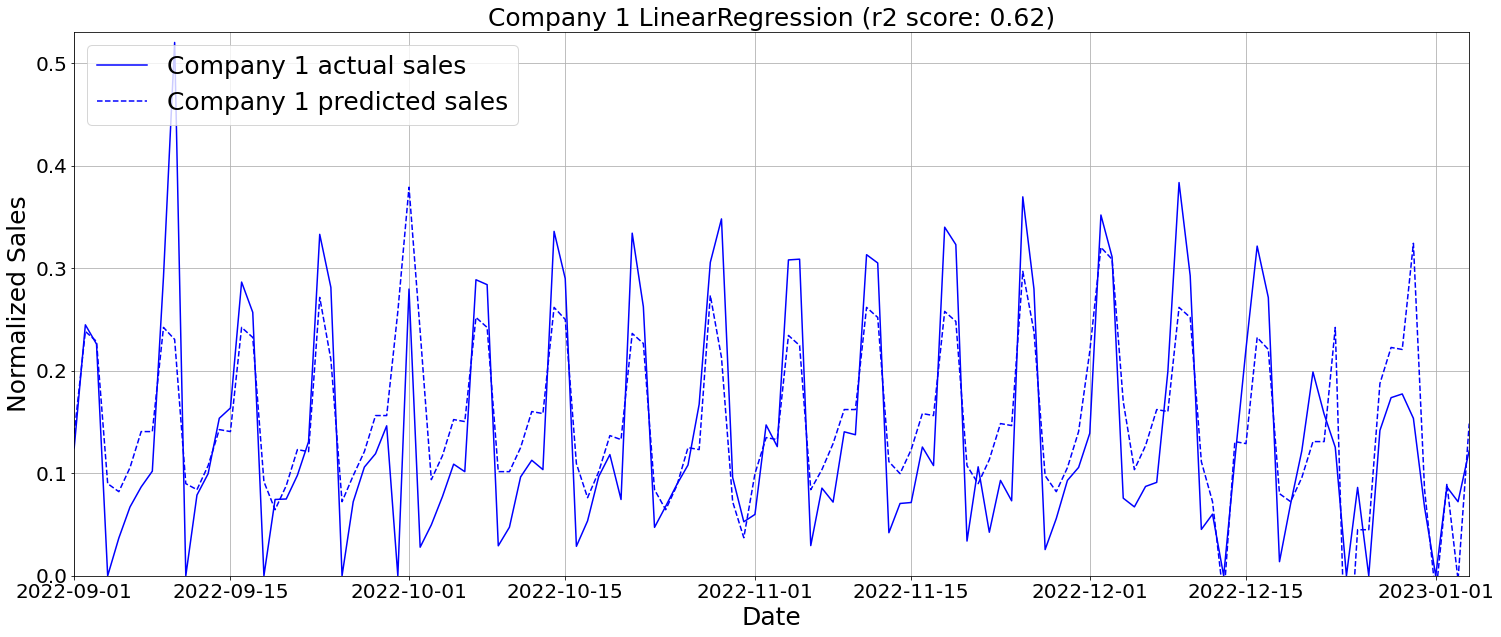

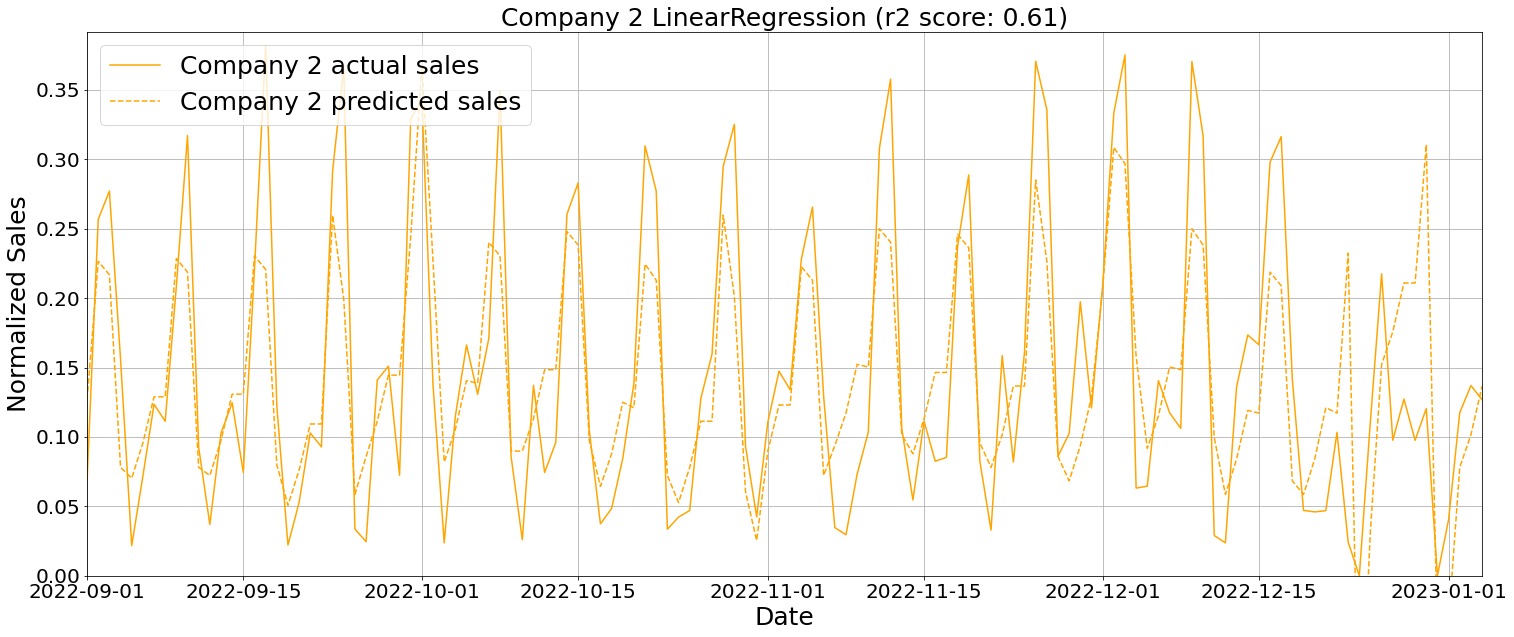

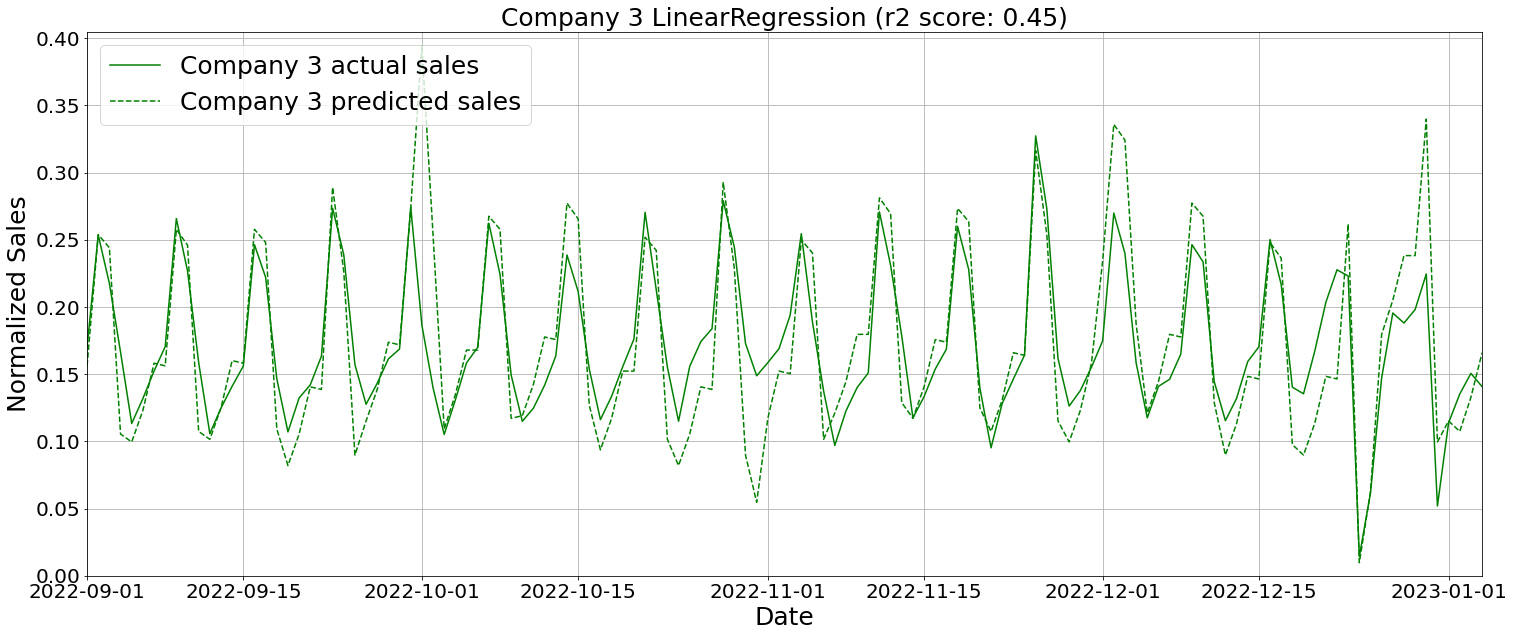

In [59]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor, VotingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

FONT_SIZE = 25

imp_sales = sales
teststart = '2022-09-01'
testend = '2023-01-04'

imp_dates = imp_sales[(imp_sales['Date'] >= teststart) & (imp_sales['Date'] <= testend)]['Date'].unique()


for company in [0,1,2]:
	# Split the data by company
	#X = sales[sales[f'Company_{company}'] == 1].drop(columns=['Sales', 'Date'])
	#y = sales[sales[f'Company_{company}'] == 1]['Sales']

	X = sales.drop(columns=['Sales', 'Date'])
	y = sales['Sales']
	X_plot = sales[(sales['Date'] >= teststart) & (sales['Date'] <= testend) & (sales[f'Company_{company}'] == 1)].drop(columns=['Sales', 'Date'])
	y_plot = sales[(sales['Date'] >= teststart) & (sales['Date'] <= testend) & (sales[f'Company_{company}'] == 1)]['Sales']
	X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.15, random_state=42)


	
	
	model = LinearRegression()

	model.fit(X_train, y_train)

	y_pred = model.predict(X_plot)
	try:
		feature_importance = pd.Series(model.feature_importances_,
						index=X_train.columns).sort_values(ascending=False)
	except:
		feature_importance = None
	# Plot the results for each company
	color = ['blue', 'orange', 'green'][company]
	fig, axs = plt.subplots(1, 1, figsize=(25, 10))
	#add legends for predicted vs actual

	axs.plot(imp_dates, y_plot, label=f'Company {company+1} actual sales', color=color)
	axs.plot(imp_dates, y_pred, label=f'Company {company+1} predicted sales', linestyle='--', color=color)
	axs.set_title(f'Company {company+1} LinearRegression (r2 score: {model.score(X_plot, y_plot):.2f})', size=FONT_SIZE)

	axs.set_xlabel('Date', size=FONT_SIZE)
	axs.set_ylabel('Normalized Sales', size=FONT_SIZE)
	axs.legend(loc='upper left', prop={'size': FONT_SIZE})
	axs.set_xlim(imp_dates[0], imp_dates[-1])
	axs.set_ylim(0, max(y_pred.max(), y_plot.max())+0.01)
	axs.tick_params(axis='both', which='major', labelsize=FONT_SIZE*0.8)
	axs.grid()

	# Plot feature importance bar chart
	if feature_importance is not None:
		fig, axs = plt.subplots(1, 1, figsize=(10, 10))
		sns.barplot(x=feature_importance[:9], y=feature_importance.index[:9], ax=axs)
		axs.set_title(f'Feature importance for Company {company+1} ({model.__class__.__name__})')
		plt.show()
